In [1]:
%load_ext autoreload
%autoreload 1

import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.append('../src')

from data.fetch_data import get_submission_docs_for_subreddit
from data.clean_data import process_text

%aimport data.fetch_data
%aimport data.clean_data

In [2]:
import pickle
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize, MWETokenizer # multi-word expression
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
from gensim import corpora, models, similarities, matutils

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [3]:
data_raw_warren = get_submission_docs_for_subreddit('ElizabethWarren')

Percent of comments by most prolific user: 0.029133711485712765


In [4]:
data_raw_sanders = get_submission_docs_for_subreddit('SandersForPresident')

Percent of comments by most prolific user: 0.007028034571348654


In [5]:
data_raw_biden = get_submission_docs_for_subreddit('JoeBiden')

Percent of comments by most prolific user: 0.03593855666119215


In [6]:
data_raw_pete = get_submission_docs_for_subreddit('Pete_Buttigieg')

Percent of comments by most prolific user: 0.022478054257038606


# Apply rDemocrats Topics

In [7]:
additional_stop_words = [
    'like', 'dont', 'im', 'say', 'did', 'said', 'thats', 'don', 'hes', 'does', 'thing', 'gt', 'sure', 'doesnt',
    'saying', 'youre', 'isnt', 'doing', 'got', 'didnt', 'yeah', 'just', 'yes',
    'right', 'think', 'going', 'want', 'know', 'good',
    'need', 'time', 'point', 'make', 'way', 'really',
    'id', 'ar', 's', 't', 've', 'm', 'shes', 
    'c', 'd', 'v', 'actually', 'look', 'maybe', 'though', 'bad', 'came', 'mods', 'things', 'lot', 'let', 'lol', 'tell', 'pretty', 'literally'
    'theyre', 'people',
    '‘', '’', '“'
]
multi_words = [
    ('health','insurance'),
    ('fox', 'news'),
    ('bernie', 'sanders'),
    ('hillary', 'clinton'),
    ('barack', 'obama'),
    ('donald', 'trump'),
    ('joe', 'biden'),
    ('joseph', 'biden'),
    ('mass', 'shooting'),
    ('mass', 'shootings'),
    ('assault', 'weapon'),
    ('assault', 'weapons'),
    ('assault', 'weapons', 'ban'),
    ('sergeant', 'at', 'arms'),
    ('stop', 'and', 'frisk'),
    ('medicare', 'for', 'all'),
    ('public', 'option'),
    ('beat', 'trump'),
    ('articles', 'of', 'impeachment'),
    ('new', 'york'),
    ('hold', 'in', 'contempt'),
    ('quid', 'pro', 'quo')
]
nmf_topic_labels = [
    '2016_election_frustration',
    'impeachment_proceedings',
    'healthcare',
    'primary_candidates',
    'gun_control',
    'election_general_terms',
    'right_wing_media',
    'impeachment',
    'yang_ubi',
    'primary_debates',
    'bloomberg',
    'econ_trump_vs_obama',
    'race_identity',
    'tax_return_ukraine_biden',
    'election_midwest_swing',
    'monetary_policy',
    'rep_dem_comparison',
    'miltary_and_immigration',
    'none'
]

In [8]:
stemmer = WordNetLemmatizer()
mwe_tokenizer = MWETokenizer(multi_words)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.lemmatize(w) for w in analyzer(doc)])

def complete_tokenizer(x):
    return mwe_tokenizer.tokenize(word_tokenize(x))

In [9]:
with open('rDemocrats_CV.pickle', 'rb') as read_file:
    cv_dems = pickle.load(read_file)
    
with open('rDemocrats_nmf.pickle', 'rb') as read_file:
    nmf_dems = pickle.load(read_file)

In [72]:
def get_topic_label(row):
    topic_weights = row['2016_election_frustration':'miltary_and_immigration']
    per_word = topic_weights / row['word_count']
    if np.max(per_word) > 0.0003:
        return nmf_topic_labels[np.argmax(topic_weights)]
    else:
        return 'none'
        

def label_primary_topic(df):
    df_ = df.copy()
    df_['primary_topic_num'] = df_.apply(get_topic_label, axis=1)
    return df_

In [73]:
def process_candidate(df):
    data_clean = df.copy()
    data_clean.text = data_clean.text.map(process_text)
    
    data_cv = cv_dems.transform(data_clean.text)
    data_dtm_raw = pd.DataFrame(data_cv.toarray(), columns=cv_dems.get_feature_names())
    data_dtm_raw.index = data_clean.index
    
    data_dtm = data_dtm_raw.iloc[:, :-171]
    
    doc_topic_nmf = nmf_dems.transform(data_dtm)
    results = pd.DataFrame(doc_topic_nmf, columns=nmf_topic_labels)
    
    return label_primary_topic(results.join(data_clean.reset_index()))

## Load Doc Topics for rDemocrats

In [100]:
with open('rDemocrats_doc_topic.pickle', 'rb') as read_file:
    doc_topic_dems = pickle.load(read_file)

In [102]:
dems_labeled = label_primary_topic(doc_topic_dems)

## Label Candidate Subreddits

In [85]:
warren_labeled_2 = process_candidate(data_raw_warren)

In [84]:
sanders_labeled_2 = process_candidate(data_raw_sanders)

In [90]:
pete_labeled_2 = process_candidate(data_raw_pete)

In [74]:
biden_labeled_2 = process_candidate(data_raw_biden)

## Get Topic Distribution for Subreddit

In [133]:
def compare_candidates(df1, df2, legend_labels):
    plt.figure(figsize=(20, 10))

    plt.ylim((0, 0.6))
    plt.hist(df1.primary_topic_num, alpha=0.4, bins=19, range=(0, 18), density=True)
    plt.hist(df2.primary_topic_num, alpha=0.4, bins=19, range=(0, 18), density=True)
    plt.xticks(rotation=90)
    plt.legend(legend_labels);

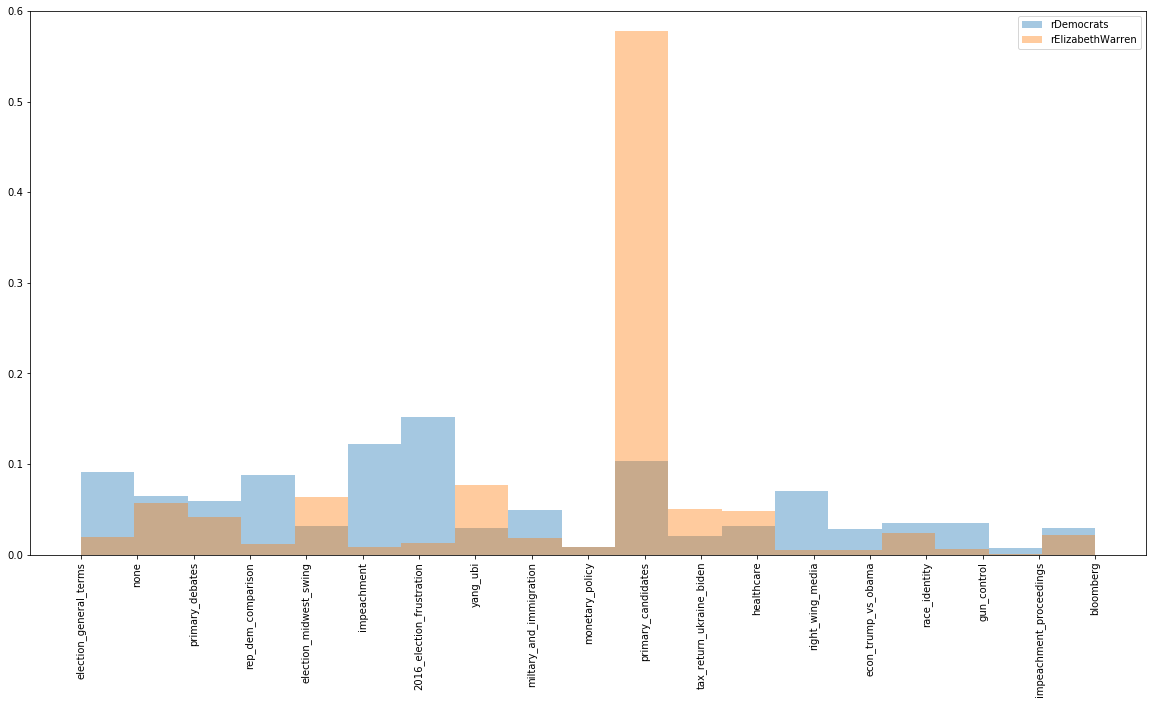

In [134]:
compare_candidates(dems_labeled, warren_labeled_2, ['rDemocrats', 'rElizabethWarren'])

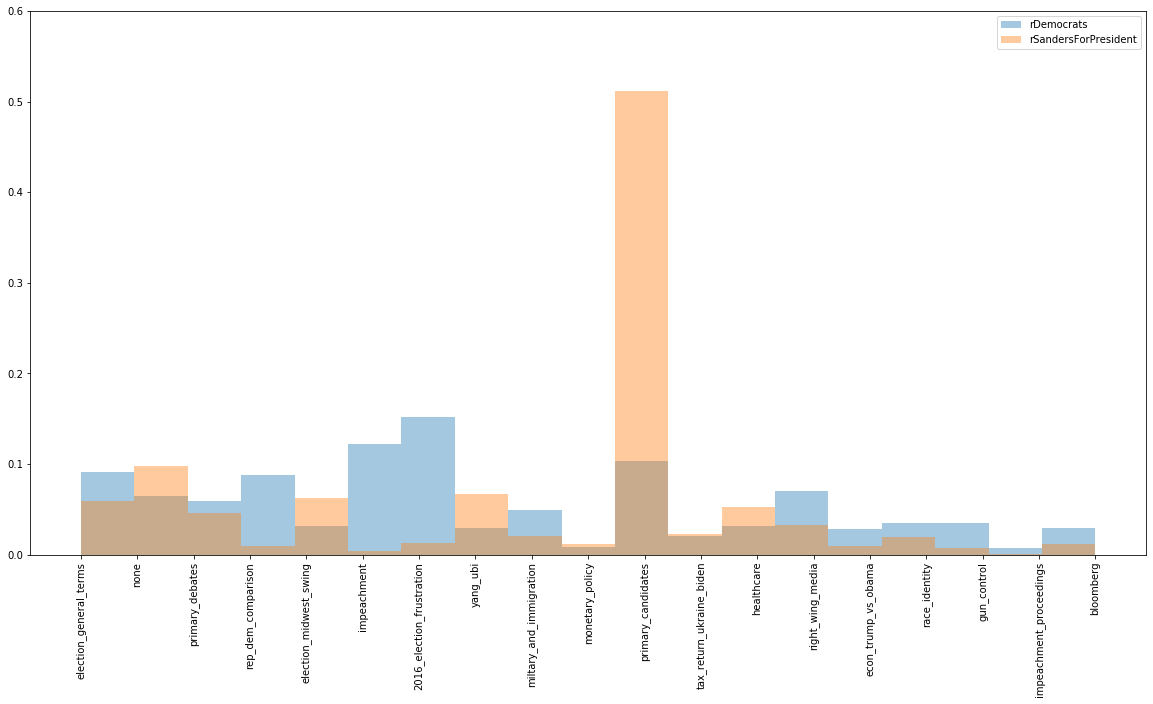

In [135]:
compare_candidates(dems_labeled, sanders_labeled_2, ['rDemocrats', 'rSandersForPresident'])

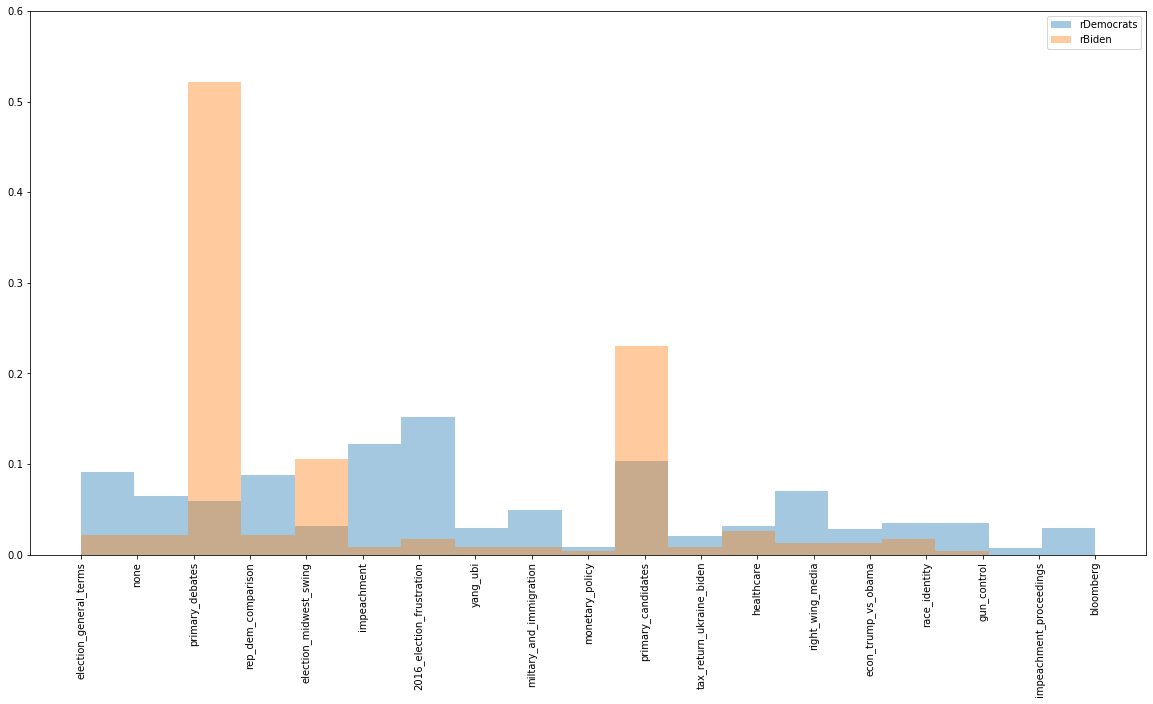

In [136]:
compare_candidates(dems_labeled, biden_labeled_2, ['rDemocrats', 'rBiden'])

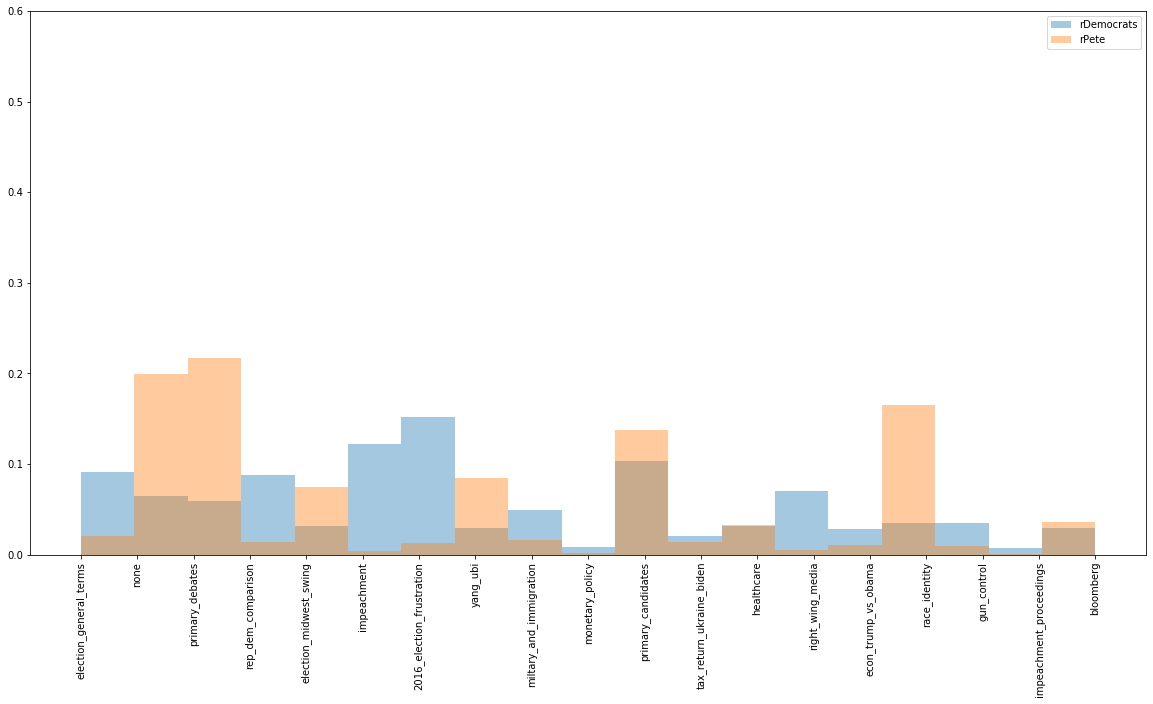

In [137]:
compare_candidates(dems_labeled, pete_labeled_2, ['rDemocrats', 'rPete'])